In [1]:
import os
from pathlib import Path
# os.environ['TPU_LOG_DIR'] = '/kaggle/working'

import pandas as pd
pd.options.mode.chained_assignment = None # avoids assignment warning
import numpy as np
import random
from glob import glob
from tqdm import tqdm
tqdm.pandas()  # enable progress bars in pandas operations
import gc

import librosa
import sklearn
import json

# Import for visualization
import matplotlib as mpl
cmap = mpl.cm.get_cmap('coolwarm')
import matplotlib.pyplot as plt
import librosa.display as lid
import IPython.display as ipd
import cv2

# Import tensorflow
import tensorflow as tf
# Set logging level to avoid unnecessary messages
tf.get_logger().setLevel('ERROR')
# Set autograph verbosity to avoid unnecessary messages
tf.autograph.set_verbosity(0)
# Enable xla for speed up
# tf.config.optimizer.set_jit(False) #  throws error for time-freq-mask

# Import required tensorflow modules
import tensorflow_io as tfio
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import tensorflow.keras.backend as K

# Import KaggleDatasets for accessing Kaggle datasets
# from kaggle_datasets import KaggleDatasets

# WandB for experiment tracking
import wandb

/tmp/ipykernel_7945/1897915493.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')
2023-05-20 12:47:14.296568: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-20 12:47:14.299345: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-20 12:47:14.352130: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-20 12:47:14.353465: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU inst

In [2]:
DATA = Path('/mnt/disk')
bc_21 = DATA / "birdclef-2021"
bc_22 = DATA / "birdclef-2022"
bc_23 = DATA / "birdclef-2023"
bsr = DATA / "birdsong-recognition"
canto = DATA / "canto"

In [3]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('librosa:', librosa.__version__)
print('tf:', tf.__version__)
print('tfp:', tfp.__version__)
print('tfa:', tfa.__version__)
print('tfio:', tfio.__version__)
print('w&b:', wandb.__version__)

np: 1.23.5
pd: 2.0.1
sklearn: 1.2.2
librosa: 0.10.0
tf: 2.12.0
tfp: 0.20.1
tfa: 0.20.0
tfio: 0.32.0
w&b: 0.15.3


## Configuration

In [4]:
class CFG:
    # Debugging
    debug = False
    
    # Verbosity level
    verbose = 0
    
    # Plot training history
    training_plot = True
    
    # Weights and Biases logging
    wandb = True
    competition   = 'birdclef-2023' 
    _wandb_kernel = 'awsaf49'
    
    # Experiment name and comment
    exp_name = 'birdclef-pretrain-v3'
    comment = 'EfficientNetB1|No-FSR|t=10s|128x384|cutmix'
    # Notebook link
    
    # Device and random seed
    device = 'TPU-VM'
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 32
    upsample_thr = 50 # min sample of each class (upsample)
    cv_filter = True # always keeps low sample data in train
    
    # Audio duration, sample rate, and length
    duration = 10 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    normalize = True
    
    # Inference batch size, test time augmentation, and drop remainder
    infer_bs = 2
    tta = 1
    drop_remainder = True
    
    # Number of epochs, model name, and number of folds
    epochs = 25
    model_name = 'EfficientNetB1'
    fsr = False # reduce stride of stem block
    num_fold = 5
    
    # Selected folds for training and evaluation
    selected_folds = [0]

    # Pretraining, neck features, and final activation function
    pretrain = 'imagenet'
    neck_features = 0
    final_act = 'softmax'
    
    # Learning rate, optimizer, and scheduler
    lr = 1e-3
    scheduler = 'cos'
    optimizer = 'Adam' # AdamW, Adam
    
    # Loss function and label smoothing
    loss = 'CCE' # BCE, CCE
    label_smoothing = 0.05 # label smoothing
    
    # Data augmentation parameters
    augment=True
    
    # Time Freq masking
    freq_mask_prob=0.50
    num_freq_masks=1
    freq_mask_param=10
    time_mask_prob=0.50
    num_time_masks=2
    time_mask_param=25

    # Audio Augmentation Settings
    audio_augment_prob = 0.5
    
    mixup_prob = 0.65
    mixup_alpha = 0.5
    
    cutmix_prob = 0.65
    cutmix_alpha = 2.5
    
    timeshift_prob = 0.0
    
    gn_prob = 0.35

    # Class Labels for BirdCLEF 23
    class_names = sorted(os.listdir('/mnt/disk/birdclef-2023/train_audio/')) #sorted(glob(str(bc_23 / 'train_audio') + '/*'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}
    
    # Class Labels for BirdCLEF 21 & 22
    class_names2 = sorted(set(os.listdir('/mnt/disk/birdclef-2021/train_short_audio/')
                       +os.listdir('/mnt/disk/birdclef-2022/train_audio/')
                       +os.listdir('/mnt/disk/birdsong-recognition/train_audio/')))
    num_classes2 = len(class_names2)
    class_labels2 = list(range(num_classes2))
    label2name2 = dict(zip(class_labels2, class_names2))
    name2label2 = {v:k for k,v in label2name2.items()}

    # Training Settings
    target_col = ['target']
    tab_cols = ['filename']
    monitor = 'auc'

In [5]:
tf.keras.utils.set_random_seed(CFG.seed)

In [6]:
# Import wandb library for logging and tracking experiments
import wandb

In [7]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    # Check TPU category
    tpu = 'local' if CFG.device=='TPU-VM' else None
    try:
        # Connect to TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu) 
        # Set TPU strategy
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on {CFG.device}', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device, tpu

In [8]:
# Initialize GPU/TPU/TPU-VM
strategy, CFG.device, tpu = get_device()
CFG.replicas = strategy.num_replicas_in_sync

> Running on CPU


In [9]:
BASE = Path('/mnt/disk')
BASE_PATH0 = BASE / 'birdsong-recognition'
BASE_PATH1 = BASE / 'birdclef-2021'
BASE_PATH2 = BASE / 'birdclef-2022'
BASE_PATH3 = BASE / 'birdclef-2023'
BASE_PATH4 = BASE / 'canto'

# if CFG.device=="TPU":
GCS_PATH0 = "gs://b-call/" + str(BASE_PATH0.parts[-1])
GCS_PATH1 = "gs://b-call/" + str(BASE_PATH1.parts[-1])
GCS_PATH2 = "gs://b-call/" + str(BASE_PATH2.parts[-1])
GCS_PATH3 = "gs://b-call/" + str(BASE_PATH3.parts[-1])
GCS_PATH4 = "gs://b-call/" + str(BASE_PATH4.parts[-1])
# else:
#     GCS_PATH0 = BASE_PATH0
#     GCS_PATH1 = BASE_PATH1
#     GCS_PATH2 = BASE_PATH2
#     GCS_PATH3 = BASE_PATH3
#     GCS_PATH4 = BASE_PATH4

## MetaData

In [10]:
df_23 = pd.read_csv(BASE_PATH3 / 'train_metadata.csv')
df_23['filepath'] = GCS_PATH3 + '/train_audio/' + df_23.filename
df_23['target'] = df_23.primary_label.map(CFG.name2label)
df_23['birdclef'] = '23'
df_23['filename'] = df_23.filepath.map(lambda x: x.split('/')[-1])
df_23['xc_id'] = df_23.filepath.map(lambda x: x.split('/')[-1].split('.')[0])
assert tf.io.gfile.exists(df_23.filepath.iloc[0])

# Display rwos
print("# Samples in BirdCLEF 23: {:,}".format(len(df_23)))
df_23.head(2).style.set_caption("BirdCLEF - 23").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'blue'),
        ('font-size', '16px')
    ]
}])


# Samples in BirdCLEF 23: 16,941


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,birdclef,xc_id
0,abethr1,[],['song'],4.390600,38.278800,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,4.000000,https://www.xeno-canto.org/128013,XC128013.ogg,gs://b-call/birdclef-2023/train_audio/abethr1/XC128013.ogg,0,23,XC128013
1,abethr1,[],['call'],-2.952400,38.292100,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,3.500000,https://www.xeno-canto.org/363501,XC363501.ogg,gs://b-call/birdclef-2023/train_audio/abethr1/XC363501.ogg,0,23,XC363501


# Samples for Pre-Training: 80,394


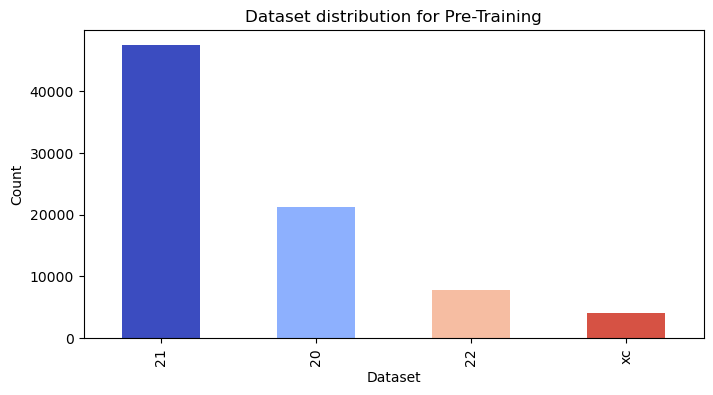

In [11]:
# BirdCLEF-2020
df_20 = pd.read_csv(BASE_PATH0 / 'train.csv')
df_20['primary_label'] = df_20['ebird_code']
df_20['filepath'] = GCS_PATH0 + '/train_audio/' + df_20.primary_label + '/' + df_20.filename
df_20['scientific_name'] = df_20['sci_name']
df_20['common_name'] = df_20['species']
df_20['target'] = df_20.primary_label.map(CFG.name2label2)
df_20['birdclef'] = '20'
assert tf.io.gfile.exists(df_20.filepath.iloc[0])

# Xeno-Canto Extend by @vopani
df_xc = pd.read_csv(BASE_PATH4 / 'train_extended.csv')
df_xc['filepath'] = GCS_PATH4 + '/' + df_xc.ebird_code + '/' + df_xc.filename
df_xc['primary_label'] = df_xc['ebird_code']
df_xc['scientific_name'] = df_xc['sci_name']
df_xc['common_name'] = df_xc['species']
df_xc['target'] = df_xc.primary_label.map(CFG.name2label2)
df_xc['birdclef'] = 'xc'
assert tf.io.gfile.exists(df_xc.filepath.iloc[0])

# BirdCLEF-2021
df_21 = pd.read_csv(BASE_PATH1 / 'train_metadata.csv')
df_21['filepath'] = GCS_PATH1 + '/train_short_audio/' + df_21.primary_label + '/' + df_21.filename
df_21['target'] = df_21.primary_label.map(CFG.name2label2)
df_21['birdclef'] = '21'
corrupt_paths = ['houwre/XC590621.ogg',
                 'cogdov/XC579430.ogg']
df_21 = df_21[~(df_21.primary_label + '/' + df_21.filename).isin(corrupt_paths)] # remove all zero audios
assert tf.io.gfile.exists(df_21.filepath.iloc[0])

# BirdCLEF-2022
df_22 = pd.read_csv(BASE_PATH2 / 'train_metadata.csv')
df_22['filepath'] = GCS_PATH2 + '/train_audio/' + df_22.filename
df_22['target'] = df_22.primary_label.map(CFG.name2label2)
df_22['birdclef'] = '22'
assert tf.io.gfile.exists(df_22.filepath.iloc[0])

# Merge 2021 and 2022 for pretraining
df_pre = pd.concat([df_20, df_21, df_22, df_xc], axis=0, ignore_index=True)
df_pre['filename'] = df_pre.filepath.map(lambda x: x.split('/')[-1])
df_pre['xc_id'] = df_pre.filepath.map(lambda x: x.split('/')[-1].split('.')[0])
nodup_idx = df_pre[['xc_id','primary_label','author']].drop_duplicates().index
df_pre = df_pre.loc[nodup_idx].reset_index(drop=True)

# # Remove duplicates
df_pre = df_pre[~df_pre.xc_id.isin(df_23.xc_id)].reset_index(drop=True)
corrupt_mp3s = json.load(open('/home/broug/Desktop/birds/birdclef-corrupt-mp3-files-ds/corrupt.json','r'))
df_pre = df_pre[~(df_pre.primary_label + '/' + df_pre.filename).isin(corrupt_mp3s)]
df_pre = df_pre[['filename','filepath','primary_label','secondary_labels',
                 'rating','author','file_type','xc_id','scientific_name',
                 'common_name','target','birdclef','bird_seen']]
# Display rows
print("# Samples for Pre-Training: {:,}".format(len(df_pre)))
df_pre.head(2).style.set_caption("Pre-Training Data").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'blue'),
        ('font-size', '16px')
    ]
}])

# Show distribution
plt.figure(figsize=(8, 4))
df_pre.birdclef.value_counts().plot.bar(color=[cmap(0.0),cmap(0.25), cmap(0.65), cmap(0.9)])
plt.xlabel("Dataset")
plt.ylabel("Count")
plt.title("Dataset distribution for Pre-Training")
plt.show()

## Data Split

In [12]:
# Import required packages
from sklearn.model_selection import StratifiedKFold

# Initialize the StratifiedKFold object with 5 splits and shuffle the data
skf1 = StratifiedKFold(n_splits=25, shuffle=True, random_state=CFG.seed)
skf2 = StratifiedKFold(n_splits=CFG.num_fold, shuffle=True, random_state=CFG.seed)

# Reset the index of the dataframe
df_pre = df_pre.reset_index(drop=True)
df_23 = df_23.reset_index(drop=True)

# Create a new column in the dataframe to store the fold number for each row
df_pre["fold"] = -1
df_23["fold"] = -1

# BirdCLEF - 21 & 22
for fold, (train_idx, val_idx) in enumerate(skf1.split(df_pre, df_pre['primary_label'])):
    df_pre.loc[val_idx, 'fold'] = fold
    
# IBirdCLEF - 23
for fold, (train_idx, val_idx) in enumerate(skf2.split(df_23, df_23['primary_label'])):
    df_23.loc[val_idx, 'fold'] = fold

/home/broug/mambaforge/envs/kag/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=25.
  warnings.warn(
/home/broug/mambaforge/envs/kag/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


## Dataframe Filtering

In [13]:
def filter_data(df, thr=5):
    # Count the number of samples for each class
    counts = df.primary_label.value_counts()

    # Condition that selects classes with less than `thr` samples
    cond = df.primary_label.isin(counts[counts<thr].index.tolist())

    # Add a new column to select samples for cross validation
    df['cv'] = True

    # Set cv = False for those class where there is samples less than thr
    df.loc[cond, 'cv'] = False

    # Return the filtered dataframe
    return df
    
def upsample_data(df, thr=20):
    # get the class distribution
    class_dist = df['primary_label'].value_counts()

    # identify the classes that have less than the threshold number of samples
    down_classes = class_dist[class_dist < thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    up_dfs = []

    # loop through the undersampled classes and upsample them
    for c in down_classes:
        # get the dataframe for the current class
        class_df = df.query("primary_label==@c")
        # find number of samples to add
        num_up = thr - class_df.shape[0]
        # upsample the dataframe
        class_df = class_df.sample(n=num_up, replace=True, random_state=CFG.seed)
        # append the upsampled dataframe to the list
        up_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    up_df = pd.concat([df] + up_dfs, axis=0, ignore_index=True)
    
    return up_df

def downsample_data(df, thr=500):
    # get the class distribution
    class_dist = df['primary_label'].value_counts()
    
    # identify the classes that have less than the threshold number of samples
    up_classes = class_dist[class_dist > thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    down_dfs = []

    # loop through the undersampled classes and upsample them
    for c in up_classes:
        # get the dataframe for the current class
        class_df = df.query("primary_label==@c")
        # Remove that class data
        df = df.query("primary_label!=@c")
        # upsample the dataframe
        class_df = class_df.sample(n=thr, replace=False, random_state=CFG.seed)
        # append the upsampled dataframe to the list
        down_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    down_df = pd.concat([df] + down_dfs, axis=0, ignore_index=True)
    
    return down_df

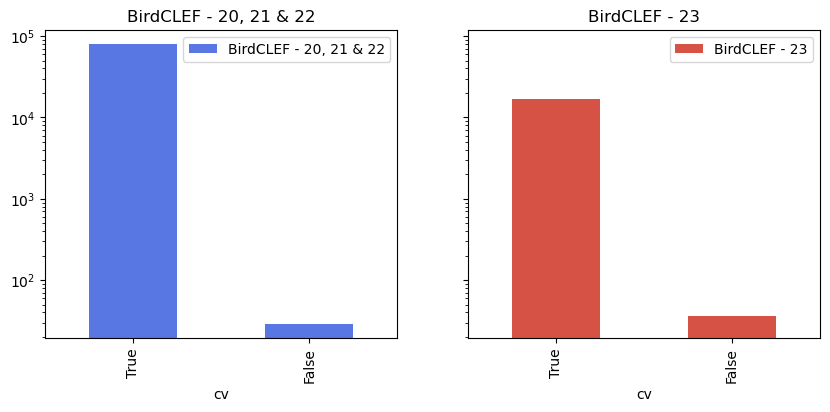

In [14]:
# Filter data
f_df = filter_data(df_pre, thr=5)

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
f_df.cv.value_counts().plot.bar(legend=True, color=cmap(0.1))
plt.yscale("log")
plt.title("BirdCLEF - 20, 21 & 22")
plt.legend(["BirdCLEF - 20, 21 & 22"])

f_df = filter_data(df_23, thr=5)
ax2 = plt.subplot(1, 2, 2, sharey = ax1)
f_df.cv.value_counts().plot.bar(legend=True, color=cmap(0.9))
plt.yscale("log")
plt.title("BirdCLEF - 23")
plt.legend(["BirdCLEF - 23"])

plt.show()

# Pretraing Dataset
> Original: 80394
> After Upsample: 88502
> After Downsample: 75805

# BirdCLEF - 23
> Before Upsample: 16941
> After Upsample: 22208


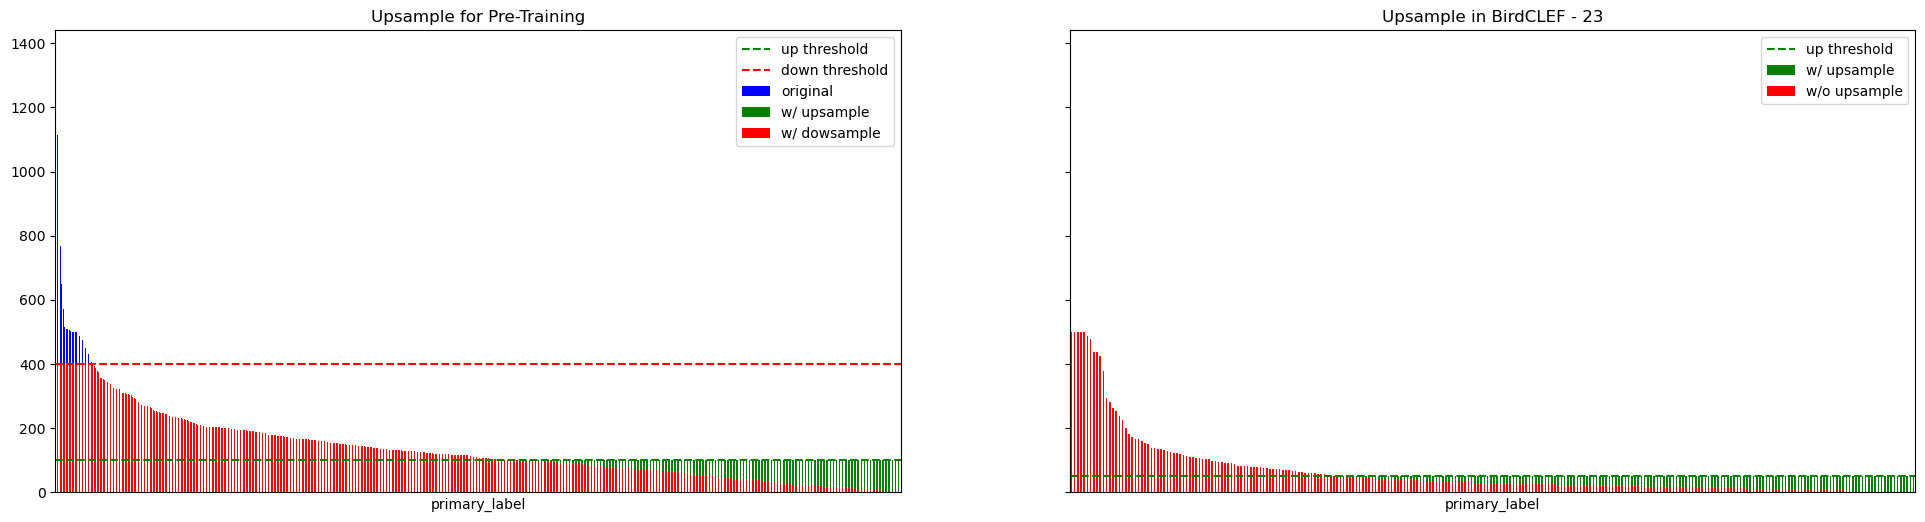

In [15]:
# Upsample data
up_thr = 100
dn_df = downsample_data(df_pre, thr=400)
up_df = upsample_data(dn_df, thr=up_thr)
print("# Pretraing Dataset")
print(f'> Original: {len(df_pre)}')
print(f'> After Upsample: {len(up_df)}')
print(f'> After Downsample: {len(dn_df)}')

# Show effect of upsample
plt.figure(figsize=(12*2, 6))

ax1 = plt.subplot(1, 2, 1)
df_pre.primary_label.value_counts()[:].plot.bar(color='blue', label='original')
up_df.primary_label.value_counts()[:].plot.bar(color='green', label='w/ upsample')
dn_df.primary_label.value_counts()[:].plot.bar(color='red', label='w/ dowsample')
plt.xticks([])
plt.axhline(y=up_thr, color='g', linestyle='--', label='up threshold')
plt.axhline(y=400, color='r', linestyle='--', label='down threshold')
plt.legend()
plt.title("Upsample for Pre-Training")
# plt.show()

# Upsample data
up_thr = 50
up_df = upsample_data(df_23, thr=up_thr)
print("\n# BirdCLEF - 23")
print(f'> Before Upsample: {len(df_23)}')
print(f'> After Upsample: {len(up_df)}')

# Show effect of upsample
ax2 = plt.subplot(1, 2, 2, sharey=ax1)
up_df.primary_label.value_counts()[:].plot.bar(color='green', label='w/ upsample')
df_23.primary_label.value_counts()[:].plot.bar(color='red', label='w/o upsample')
plt.xticks([])
plt.axhline(y=up_thr, color='g', linestyle='--', label='up threshold')
plt.legend()
plt.title("Upsample in BirdCLEF - 23")

# plt.tight_layout()
plt.show()

## Augmentations

### Utilities

In [16]:
# Generates random integer
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)


# Generats random float
def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

### Audio Aug

In [17]:
# Import required packages
import tensorflow_extra as tfe

# Randomly shift audio -> any sound at <t> time may get shifted to <t+shift> time
@tf.function
def TimeShift(audio, prob=0.5):
    # Randomly apply time shift with probability `prob`
    if random_float() < prob:
        # Calculate random shift value
        shift = random_int(shape=[], minval=0, maxval=tf.shape(audio)[0])
        # Randomly set the shift to be negative with 50% probability
        if random_float() < 0.5:
            shift = -shift
        # Roll the audio signal by the shift value
        audio = tf.roll(audio, shift, axis=0)
    return audio

# Apply random noise to audio data
@tf.function
def GaussianNoise(audio, std=[0.0025, 0.025], prob=0.5):
    # Select a random value of standard deviation for Gaussian noise within the given range
    std = random_float([], std[0], std[1])
    # Randomly apply Gaussian noise with probability `prob`
    if random_float() < prob:
        # Add random Gaussian noise to the audio signal
        GN = tf.keras.layers.GaussianNoise(stddev=std)
        audio = GN(audio, training=True) # training=False don't apply noise to data
    return audio

# Applies augmentation to Audio Signal
def AudioAug(audio):
    # Apply time shift and Gaussian noise to the audio signal
    audio = TimeShift(audio, prob=CFG.timeshift_prob)
    audio = GaussianNoise(audio, prob=CFG.gn_prob)
    return audio

# CutMix & MixUp
mixup_layer = tfe.layers.MixUp(alpha=CFG.mixup_alpha, prob=CFG.mixup_prob)
cutmix_layer = tfe.layers.CutMix(alpha=CFG.cutmix_alpha, prob=CFG.cutmix_prob)

def CutMixUp(audios, labels):
    audios, labels = mixup_layer(audios, labels, training=True)
    audios, labels = cutmix_layer(audios, labels, training=True)
    return audios, labels

## Dataloader

In [18]:
# Decodes Audio
def audio_decoder(with_labels=True, dim=CFG.audio_len, 
                  take_first=False, num_classes=264, CFG=CFG):
    def get_audio(filepath):
        ftype = filepath[1]
        filepath = filepath[0]
        file_bytes = tf.io.read_file(filepath)
        if ftype:
            audio = tfio.audio.decode_vorbis(file_bytes) # decode .ogg file
        else:
            audio = tfio.audio.decode_mp3(file_bytes) # decode .mp3 file
        audio = tf.cast(audio, tf.float32)
        if tf.shape(audio)[1]>1: # stereo -> mono
            audio = audio[...,0:1]
        audio = tf.squeeze(audio, axis=-1)
        return audio
    
    def crop_or_pad(audio, target_len, pad_mode='constant', take_first=True):
        audio_len = tf.shape(audio)[0]
        diff_len = abs(target_len - audio_len)
        if audio_len < target_len:
            pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            pad2 = diff_len - pad1
            audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)
        elif audio_len > target_len:
            if take_first:
                audio = audio[:target_len]
            else:
                idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
                audio = audio[idx: (idx + target_len)]
        return tf.reshape(audio, [target_len])

    def get_target(target):          
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, num_classes), tf.float32) 
        target = tf.reshape(target, [num_classes])
        return target

    def decode(path):
        audio = get_audio(path)
        audio = crop_or_pad(audio, dim) # crop or pad audio to keep a fixed length
        audio = tf.reshape(audio, [dim])
        return audio
    
    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label
    
    return decode_with_labels if with_labels else decode

In [19]:
# Applies augmentation to audio
def audio_augmenter(with_labels=True, dim=CFG.audio_len, CFG=CFG):
    def augment(audio, dim=dim):
        if random_float() <= CFG.audio_augment_prob:
            audio = AudioAug(audio)
        audio = tf.reshape(audio, [dim])
        return audio
    
    def augment_with_labels(audio, label):    
        return augment(audio), label
    
    return augment_with_labels if with_labels else augment

## Pipeline

In [20]:
def build_dataset(paths, ftype, labels=None, batch_size=32, target_size=[128, 256], 
                  audio_decode_fn=None, audio_augment_fn=None,
                  take_first=False, num_classes=264,
                  cache=True, cache_dir="",drop_remainder=False,
                  augment=True, repeat=True, shuffle=1024):
    """
    Creates a TensorFlow dataset from the given paths and labels.
    
    Args:
        paths (list): A list of file paths to the audio files.
        labels (list): A list of corresponding labels for the audio files.
        batch_size (int): Batch size for the created dataset.
        target_size (list): A list of target image size for the spectrograms.
        audio_decode_fn (function): A function to decode the audio file.
        audio_augment_fn (function): A function to augment the audio file.
        cache (bool): Whether to cache the dataset or not.
        cache_dir (str): Directory path to cache the dataset.
        drop_remainder (bool): Whether to drop the last batch if it is smaller than batch_size.
        augment (bool): Whether to augment the dataset or not.
        repeat (bool): Whether to repeat the dataset or not.
        shuffle (int): Number of elements from the dataset to buffer for shuffling.
        
    Returns:
        ds (tf.data.Dataset): A TensorFlow dataset.
    """
    # Create cache directory if cache is enabled
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    # Set default audio decode function if not provided
    if audio_decode_fn is None:
        audio_decode_fn = audio_decoder(labels is not None,
                                        dim=CFG.audio_len, 
                                        take_first=take_first,
                                        num_classes=num_classes,
                                        CFG=CFG)
    # Set default audio augmentation function if not provided
    if audio_augment_fn is None:
        audio_augment_fn = audio_augmenter(labels is not None, 
                                           dim=CFG.audio_len, CFG=CFG)
        
    # Set TensorFlow AUTOTUNE option
    AUTO = tf.data.experimental.AUTOTUNE
    # Create slices based on whether labels are provided
    slices = ((paths, ftype),) if labels is None else ((paths, ftype), labels)
    # Create TensorFlow dataset from slices
    ds = tf.data.Dataset.from_tensor_slices(slices)
    # Map audio decode function to dataset
    ds = ds.map(audio_decode_fn, num_parallel_calls=AUTO)
    # Cache dataset in memory if cache is enabled
    ds = ds.cache(cache_dir) if cache else ds
    # Repeat dataset indefinitely if repeat is enabled
    ds = ds.repeat() if repeat else ds
    # Create TensorFlow dataset options
    opt = tf.data.Options()
    # Shuffle dataset if shuffle is enabled
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
    if CFG.device=='GPU':
        # If the device is a GPU, turn off auto-sharding to avoid performance issues
        opt.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
    # Set the options for the dataset
    ds = ds.with_options(opt)
    # Apply audio augmentation to the dataset if augment is True
    ds = ds.map(audio_augment_fn, num_parallel_calls=AUTO) if augment else ds
    # Batch the dataset with the specified batch size
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    # Apply MixUp & CutMix regularization to the dataset
    if augment and labels is not None:
        ds = ds.map(CutMixUp,num_parallel_calls=AUTO)
    # Prefetch the next batch of data to improve performance
    ds = ds.prefetch(AUTO)
    return ds

## Visual Aides

In [21]:
def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        audios, tars = batch
    else:
        audios = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        plt.plot(audios[idx].numpy(), color=cmap(0.1))
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()
    
    
def plot_history(history):
    """Plot trainign history, credit: @cdeotte"""
    epochs = len(history.history['auc'])
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(epochs),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    plt.plot(np.arange(epochs),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
    x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC (PR)',size=14); plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(epochs),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(epochs),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('Fold %i - Training Plot'%(fold+1),size=18)
    plt.legend(loc=3)
    plt.show()  

### Birdclef 20

2023-05-20 12:07:50.710234: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA
2023-05-20 12:07:51.802401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-05-20 12:07:51.802549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-05-20 12:07:51.812739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can 

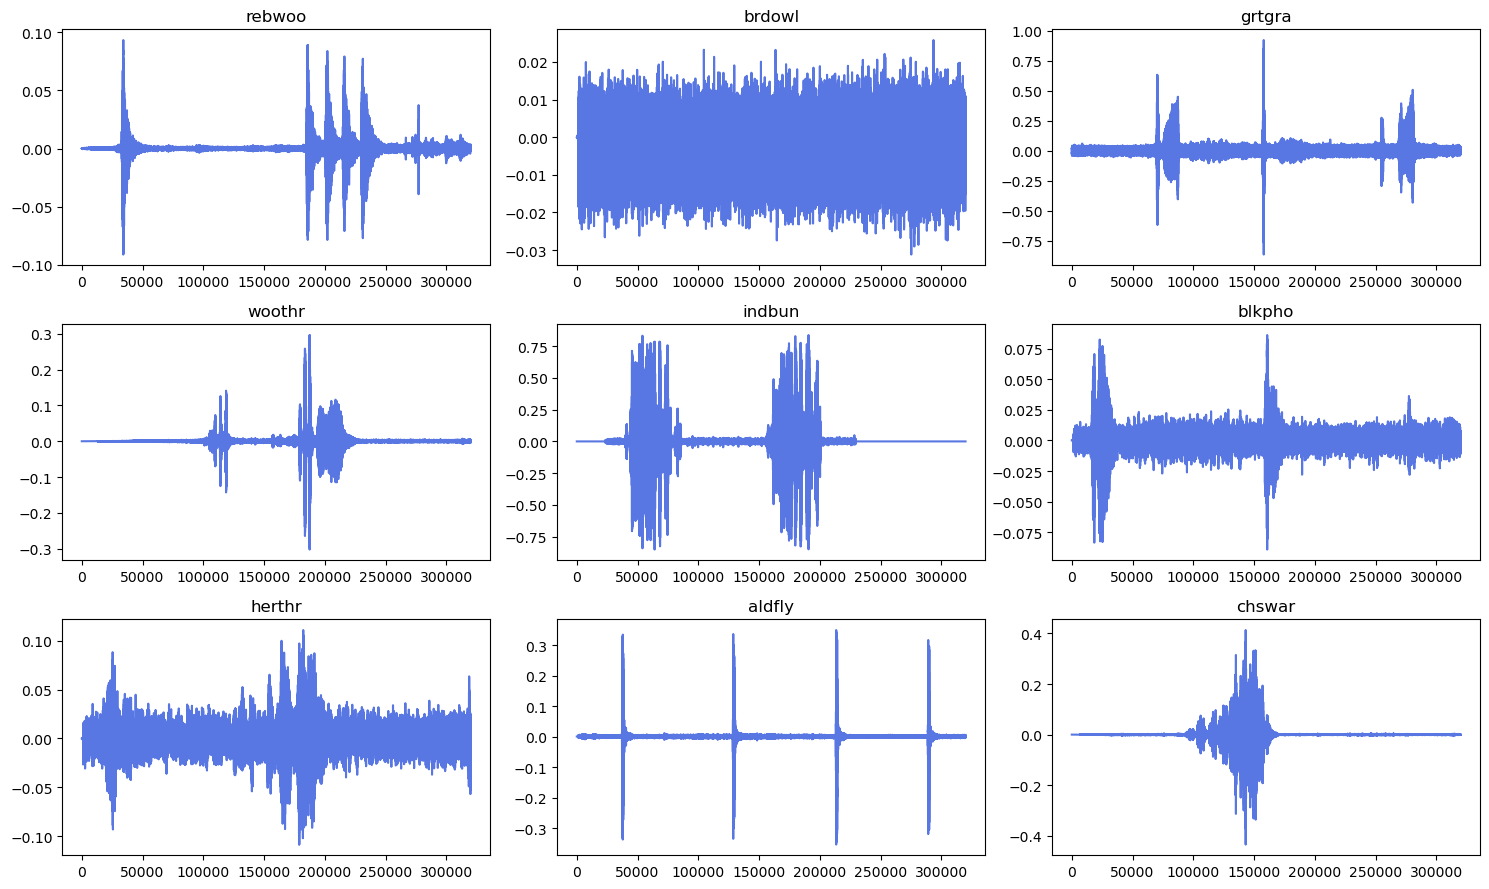

In [22]:
check_df = df_pre.query("birdclef=='20'").sample(50)
ds = build_dataset(check_df.filepath.tolist(),
                   check_df.filepath.str.contains('.ogg').tolist(),
                   check_df.target.tolist(), 
                   num_classes=CFG.num_classes2,
                   augment=True, cache=False)
ds = ds.take(32)
audios, labels = next(iter(ds))
plot_batch((audios, labels), label2name=CFG.label2name2)

2023-05-20 12:13:49.987688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [50]
	 [[{{node Placeholder/_0}}]]
2023-05-20 12:13:49.988041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype bool and shape [50]
	 [[{{node Placeholder/_1}}]]
2023-05-20 12:14:00.466409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 300 of 1024
2023-05-20 12:14:10.298488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 565 of 1024
2023-05-20 12:14:20.

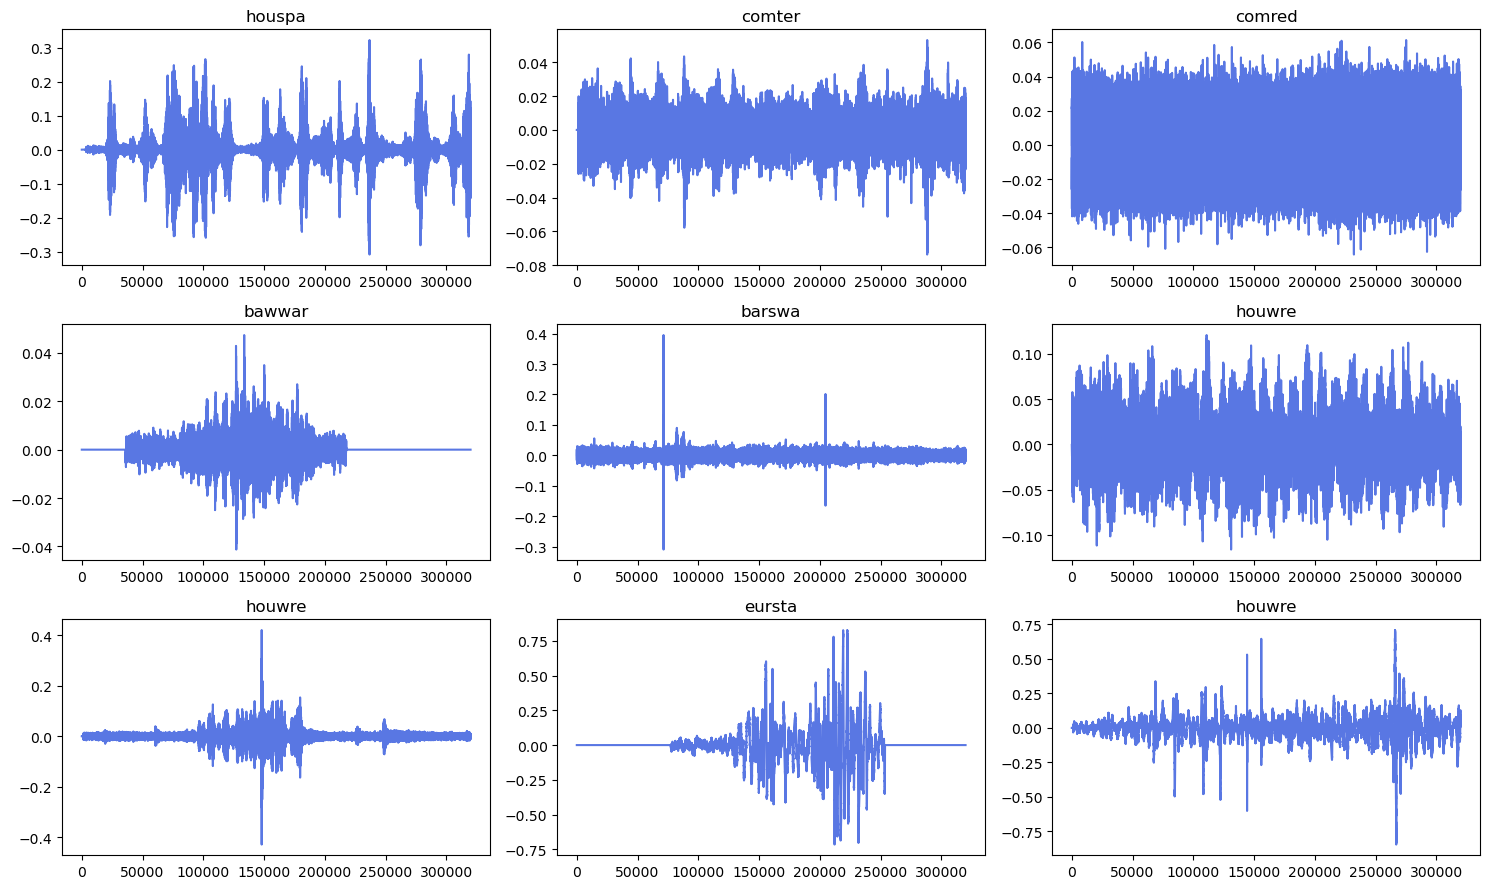

In [24]:
gc.collect()

check_df = df_pre.query("birdclef=='xc'").sample(50)
ds = build_dataset(check_df.filepath.tolist(),
                   check_df.filepath.str.contains('.ogg').tolist(),
                   check_df.target.tolist(), 
                   num_classes=CFG.num_classes2,
                   augment=True, cache=False)
ds = ds.take(32)
audios, labels = next(iter(ds))
plot_batch((audios, labels), label2name=CFG.label2name2)

In [25]:
del audios, labels, ds

### 23

2023-05-20 12:48:13.443224: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA
2023-05-20 12:48:14.377102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-05-20 12:48:14.377241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-05-20 12:48:14.388175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can 

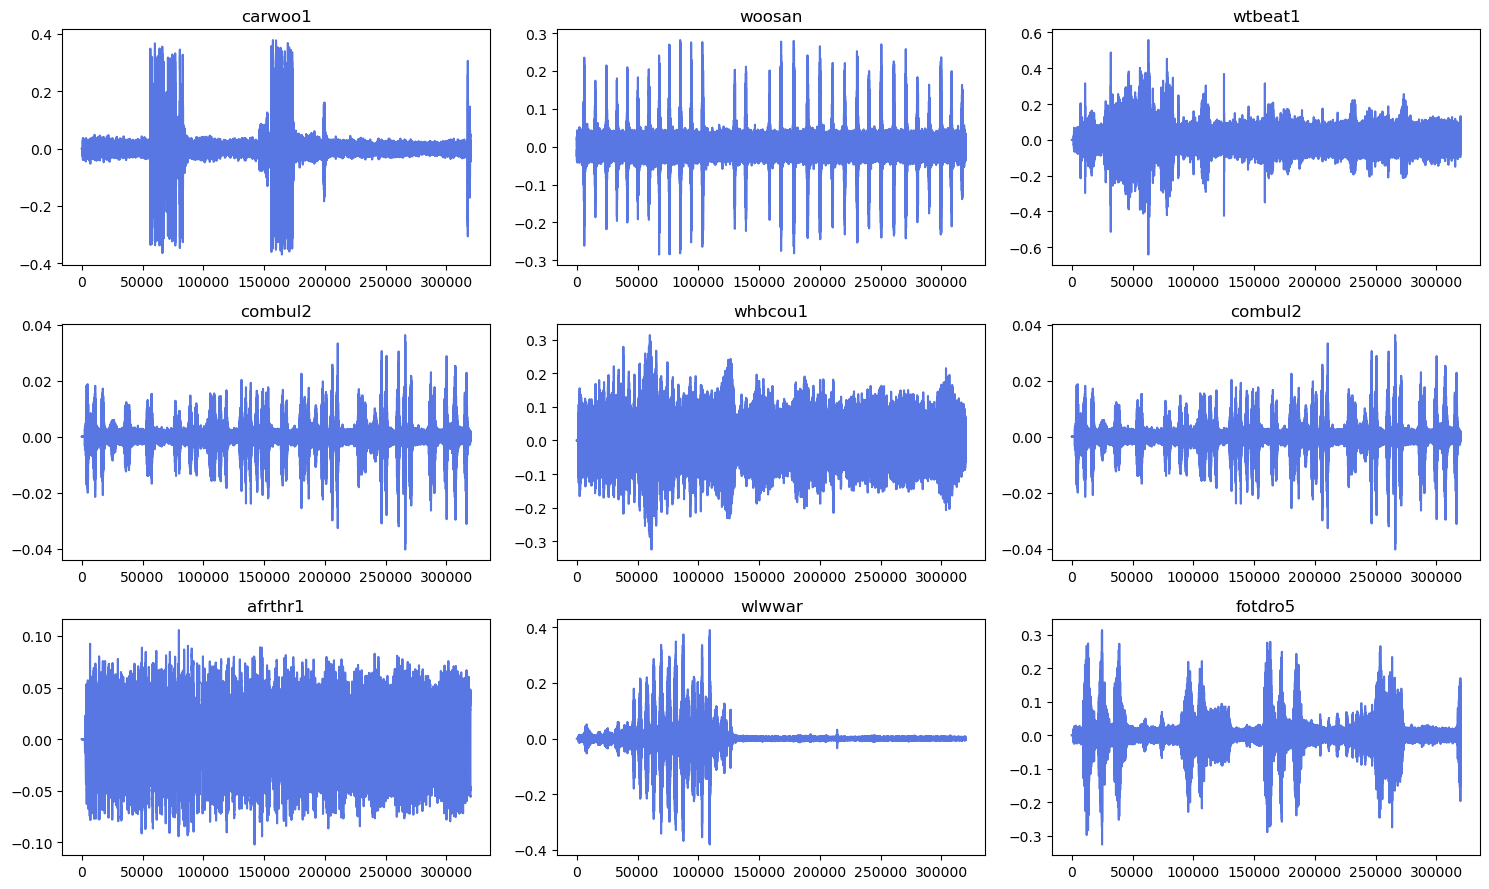

In [23]:
check_df = df_23.sample(50)
ds = build_dataset(check_df.filepath.tolist(),
                   check_df.filepath.str.contains('.ogg').tolist(),
                   check_df.target.tolist(), 
                   num_classes=CFG.num_classes2,
                   augment=True, cache=False)
ds = ds.take(32)
audios, labels = next(iter(ds))
plot_batch((audios, labels), label2name=CFG.label2name)

## Preprocessing

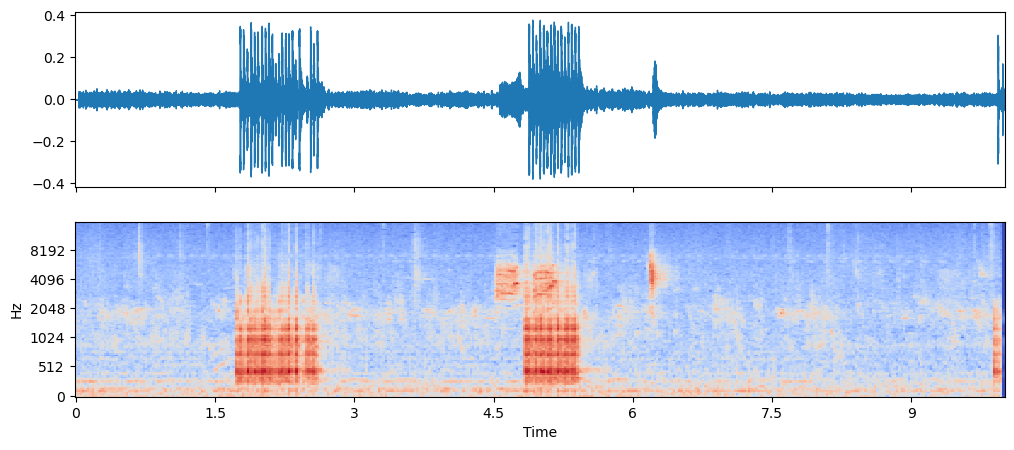

In [24]:
melspec_layer = tfe.layers.MelSpectrogram(n_fft=CFG.nfft, 
                                          hop_length=CFG.hop_length, 
                                          sr=CFG.sample_rate, 
                                          ref=1.0,
                                          fmin=500,
                                          fmax=15000,
                                          out_channels=3)
specs = melspec_layer(audios)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
lid.waveshow(audios[0].numpy(), sr=CFG.sample_rate, ax=ax[0], axis=None)

lid.specshow(specs[0, ..., 0].numpy(), 
             n_fft=CFG.nfft, 
             hop_length=CFG.hop_length, 
             sr=CFG.sample_rate,
             x_axis='time',
             y_axis='mel',
             cmap='coolwarm',
              ax=ax[1])
plt.show()

### Time Frequency Masking

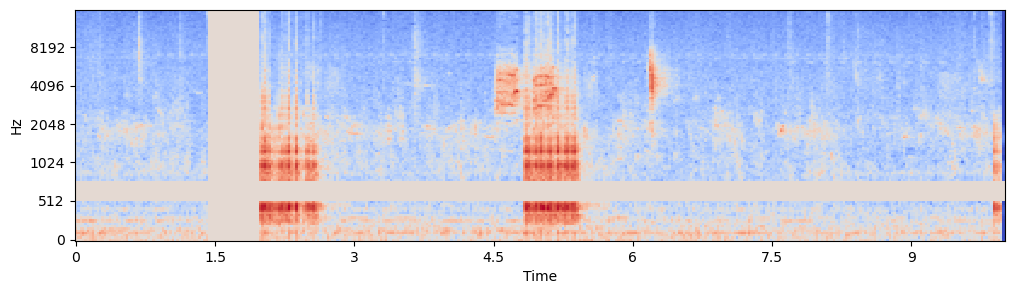

In [25]:
tfm_layer = tfe.layers.TimeFreqMask(freq_mask_prob=0.65,
                                  num_freq_masks=2,
                                  freq_mask_param=10,
                                  time_mask_prob=0.65,
                                  num_time_masks=3,
                                  time_mask_param=25,
                                  time_last=True,)
specs2 = tfm_layer(specs, training=True)

plt.figure(figsize=(12,3))
lid.specshow(specs2[0, ..., 0].numpy(), 
             n_fft=CFG.nfft, 
             hop_length=CFG.hop_length, 
             sr=CFG.sample_rate,
            x_axis='time',
            y_axis='mel',
            cmap='coolwarm')
plt.show()

### Normalization

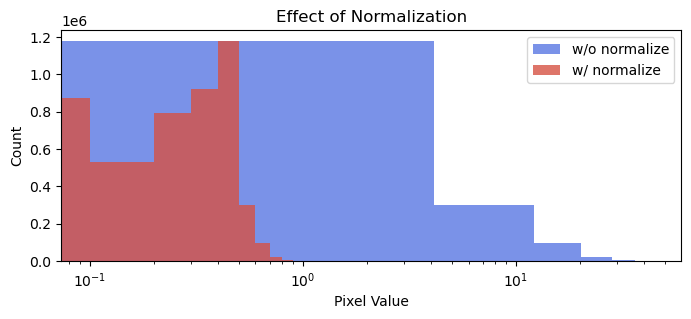

In [26]:
norm_layer = tfe.layers.ZScoreMinMax()
specs3 = norm_layer(specs2)

plt.figure(figsize=(8,3))
plt.hist(specs2.numpy().ravel(), alpha=0.8, color=cmap(0.1))
plt.hist(specs3.numpy().ravel(), alpha=0.8, color=cmap(0.9))
plt.legend(["w/o normalize", "w/ normalize"])
plt.semilogx()
plt.title("Effect of Normalization")
plt.xlabel("Pixel Value")
plt.ylabel("Count")
plt.show()

## Modelling

### Loss, Optimizer and Metric

In [27]:
import sklearn.metrics

def get_metrics():
#     acc = tf.keras.metrics.BinaryAccuracy(name='acc')
    auc = tf.keras.metrics.AUC(curve='PR', name='auc', multi_label=False) # auc on prcision-recall curve
    acc = tf.keras.metrics.CategoricalAccuracy(name='acc')
    return [acc, auc]

def padded_cmap(y_true, y_pred, padding_factor=5):
    num_classes = y_true.shape[1]
    pad_rows = np.array([[1]*num_classes]*padding_factor)
    y_true = np.concatenate([y_true, pad_rows])
    y_pred = np.concatenate([y_pred, pad_rows])
    score = sklearn.metrics.average_precision_score(y_true, y_pred, average='macro',)
    return score

def get_loss():
    if CFG.loss=="CCE":
        loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=CFG.label_smoothing)
    elif CFG.loss=="BCE":
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=CFG.label_smoothing)
    else:
        raise ValueError("Loss not found")
    return loss
    
def get_optimizer():
    if CFG.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=CFG.lr)
    else:
        raise ValueError("Optmizer not found")
    return opt

### Build Model

In [28]:
import efficientnet.tfkeras as efn
import tensorflow_extra as tfe

# Will download and load pretrained imagenet weights.
def build_model(CFG, model_name=None, num_classes=264, compile_model=True):
    """
    Builds and returns a model based on the specified configuration.
    """
    # Create an input layer for the model
    inp = tf.keras.layers.Input(shape=(None,))
    # Spectrogram
    out = tfe.layers.MelSpectrogram(n_mels=CFG.img_size[0],
                                    n_fft=CFG.nfft,
                                    hop_length=CFG.hop_length, 
                                    sr=CFG.sample_rate,
                                    ref=1.0,
                                    out_channels=3)(inp)
    # Normalize
    out = tfe.layers.ZScoreMinMax()(out)
    # TimeFreqMask
    out = tfe.layers.TimeFreqMask(freq_mask_prob=0.5,
                                  num_freq_masks=1,
                                  freq_mask_param=10,
                                  time_mask_prob=0.5,
                                  num_time_masks=2,
                                  time_mask_param=25,
                                  time_last=False,)(out)
    # Load backbone model
    base = getattr(efn, model_name)(input_shape=(None, None, 3),
                                            include_top=0,
                                            weights=CFG.pretrain,
                                           fsr=CFG.fsr)
    # Pass the input through the base model
    out = base(out)
    out = tf.keras.layers.GlobalAveragePooling2D()(out)
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(out)
    model = tf.keras.models.Model(inputs=inp, outputs=out)
    if compile_model:
        # Set the optimizer
        opt = get_optimizer()
        # Set the loss function
        loss = get_loss()
        # Set the evaluation metrics
        metrics = get_metrics()
        # Compile the model with the specified optimizer, loss function, and metrics
        model.compile(optimizer=opt, loss=loss, metrics=metrics)
    return model

In [29]:
model = build_model(CFG, model_name=CFG.model_name)
model.summary()

2023-05-20 12:49:44.810184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,?]
	 [[{{node Placeholder}}]]


27164032/27164032 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 mel_spectrogram (MelSpectro  (None, 128, None, 3)     0         
 gram)                                                           
                                                                 
 z_score_min_max (ZScoreMinM  (None, 128, None, 3)     0         
 ax)                                                             
                                                                 
 time_freq_mask (TimeFreqMas  (None, 128, None, 3)     0         
 k)                                                              
                                                                 
 efficientnet-b1 (Functional  (None, None, None, 1280)  657523

### Learning Rate Schedule

In [30]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=CFG.epochs, plot=False):
    """
    Returns a learning rate scheduler callback for a given batch size, mode, and number of epochs.
    """
    # Define the learning rate schedule.
    lr_start   = 0.000005
    lr_max     = 0.00000140 * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    # Function to update the lr
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max

        elif CFG.scheduler == 'exp':
            lr = (lr_max - lr_min) * lr_decay**(epoch - \
                  lr_ramp_ep - lr_sus_ep) + lr_min

        elif CFG.scheduler == 'step':
            lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)

        elif CFG.scheduler == 'cos':
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            cosine_decay = 0.5 * (1 + math.cos(phase))
            lr = (lr_max - lr_min) * cosine_decay + lr_min
        return lr
    
    # Plot the lr curve
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()
        
    # Crate lr-callback to update lr during training
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

## Wandb

In [31]:
import yaml

def wandb_init(fold):
    """
    Initializes the W&B run by creating a config file and initializing a W&B run.
    """
    # Create a dictionary of configuration parameters
    config = {k:v for k,v in dict(vars(CFG)).items() if '__' not in k}
    config.update({"fold":int(fold)}) # int is to convert numpy.int -> int
    # Dump the configuration dictionary to a YAML file
    yaml.dump(config, open(f'/kaggle/working/config fold-{fold}.yaml', 'w'),)
    # Load the configuration dictionary from the YAML file
    config = yaml.load(open(f'/kaggle/working/config fold-{fold}.yaml', 'r'), Loader=yaml.FullLoader)
    # Initialize a W&B run with the given configuration parameters
    run = wandb.init(project="birdclef-2023",
                     name=f"fold-{fold}|dim-{CFG.img_size[1]}x{CFG.img_size[0]}|model-{CFG.model_name}",
                     config=config,
                     group=CFG.comment,
                     save_code=True,)
    return run

    
def log_wandb(valid_df):
    """Log and save validation results with missclassified examples as audio in W&B"""
    # Query only the rows with miss predictions
    save_df = valid_df.query("miss==True")
    # Map the predicted and target labels to their corresponding names
    save_df.loc[:, 'pred_name'] = save_df.pred.map(CFG.label2name)
    save_df.loc[:, 'target_name'] = save_df.target.map(CFG.label2name)
    # Trim the dataframe for debugging purposes
    if CFG.debug:
        save_df = save_df.iloc[:CFG.replicas*CFG.batch_size*CFG.infer_bs]
    # Get the columns to be included in the wandb table
    noimg_cols = [*CFG.tab_cols, 'target', 'pred', 'target_name','pred_name']
    # Retain only the necessary columns
    save_df = save_df.loc[:, noimg_cols]

    data = []
    # Load audio files for each miss prediction
    for idx, row in tqdm(save_df.iterrows(), total=len(save_df), desc='wandb ', position=0, leave=True):
        filepath = '/mnt/disk/birdclef-2023/train_audio/'+CFG.label2name[row.target]+'/'+row.filename
        audio, sr = librosa.load(filepath, sr=None)
        # Add the audio file to the data list along with the other relevant information
        data+=[[*row.tolist(), wandb.Audio(audio, caption=row.filename, sample_rate=sr)]]
    # Create a wandb table with the audio files and other relevant information
    wandb_table = wandb.Table(data=data, columns=[*noimg_cols, 'audio'])
    # Manually unpack dict values
    scores_wb = {f'best.{k}': v for k,v in scores.items()}
    # Log the scores and wandb table to wandb
    wandb.log({**scores_wb,
               'table': wandb_table,
               })
    
# get wandb callbacks
def get_wb_callbacks(fold):
    wb_ckpt = wandb.keras.WandbModelCheckpoint(filepath='fold-%i.h5'%fold, 
                                               monitor='val_auc',
                                               verbose=CFG.verbose,
                                               save_best_only=True,
                                               save_weights_only=False,
                                               mode='max',)
    wb_metr = wandb.keras.WandbMetricsLogger()
    return [wb_ckpt, wb_metr]

## Pretraining

In [32]:
# Configurations
num_classes = CFG.num_classes2
df = df_pre.copy()
fold = 0

# Compute batch size and number of samples to drop
infer_bs = (CFG.batch_size*CFG.infer_bs)
drop_remainder = CFG.drop_remainder

# Split dataset with cv filter
if CFG.cv_filter:
    df = filter_data(df, thr=5)
    train_df = df.query("fold!=@fold | ~cv").reset_index(drop=True)
    valid_df = df.query("fold==@fold & cv").reset_index(drop=True)
else:
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)

# Upsample train data
train_df = upsample_data(train_df, thr=50)
train_df = downsample_data(train_df, thr=500)

# Get file paths and labels
train_paths = train_df.filepath.values; train_labels = train_df.target.values
valid_paths = valid_df.filepath.values; valid_labels = valid_df.target.values

# Shuffle the file paths and labels
index = np.arange(len(train_paths))
np.random.shuffle(index)
train_paths  = train_paths[index]
train_labels = train_labels[index]

# For debugging
if CFG.debug:
    min_samples = CFG.batch_size*CFG.replicas*2
    train_paths = train_paths[:min_samples]; train_labels = train_labels[:min_samples]
    valid_paths = valid_paths[:min_samples]; valid_labels = valid_labels[:min_samples]
    
# Ogg or Mp3
train_ftype = list(map(lambda x: '.ogg' in x, train_paths))
valid_ftype = list(map(lambda x: '.ogg' in x, valid_paths))

# Compute the number of training and validation samples
num_train = len(train_paths); num_valid = len(valid_paths)

# Build the training and validation datasets
cache=False
train_ds = build_dataset(train_paths, train_ftype, train_labels, 
                         batch_size=CFG.batch_size*CFG.replicas, cache=cache, shuffle=True,
                        drop_remainder=drop_remainder, num_classes=num_classes)
valid_ds = build_dataset(valid_paths, valid_ftype, valid_labels,
                         batch_size=CFG.batch_size*CFG.replicas, cache=True, shuffle=False,
                         augment=False, repeat=False, drop_remainder=drop_remainder,
                         take_first=True, num_classes=num_classes)

# Print information about the fold and training
print('#'*25); print('#### Pre-Training')
print('#### Image Size: (%i, %i) | Model: %s | Batch Size: %i | Scheduler: %s'%
      (*CFG.img_size, CFG.model_name, CFG.batch_size*CFG.replicas, CFG.scheduler))
print('#### Num Train: {:,} | Num Valid: {:,}'.format(len(train_paths), len(valid_paths)))

# Clear the session and build the model
K.clear_session()
with strategy.scope():
    model = build_model(CFG, model_name=CFG.model_name, num_classes=num_classes)

print('#'*25) 

# Checkpoint Callback
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    'birdclef_pretrained_ckpt.h5', monitor='val_auc', verbose=0, save_best_only=True,
    save_weights_only=False, mode='max', save_freq='epoch')
# LR Scheduler Callback
lr_cb = get_lr_callback(CFG.batch_size*CFG.replicas)
callbacks = [ckpt_cb, lr_cb]

# Training
history = model.fit(
    train_ds, 
    epochs=2 if CFG.debug else CFG.epochs, 
    callbacks=callbacks, 
    steps_per_epoch=len(train_paths)/CFG.batch_size//CFG.replicas,
    validation_data=valid_ds, 
    verbose=CFG.verbose,
)

# Show training plot
if CFG.training_plot:
    plot_history(history)

#########################
#### Pre-Training
#### Image Size: (128, 384) | Model: EfficientNetB1 | Batch Size: 32 | Scheduler: cos
#### Num Train: 78,407 | Num Valid: 3,216


2023-05-20 12:53:25.202494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,?]
	 [[{{node Placeholder}}]]


#########################


2023-05-20 12:53:28.727944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [78407]
	 [[{{node Placeholder/_2}}]]
2023-05-20 12:53:28.728284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [78407]
	 [[{{node Placeholder/_2}}]]


ValueError: in user code:

    File "/home/broug/mambaforge/envs/kag/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/broug/mambaforge/envs/kag/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/broug/mambaforge/envs/kag/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/broug/mambaforge/envs/kag/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/broug/mambaforge/envs/kag/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_fileh1vivjzr.py", line 69, in tf__call
        ag__.if_stmt(ag__.not_(ag__.ld(training)), if_body, else_body, get_state_2, set_state_2, ('do_return', 'retval_'), 2)
    File "/tmp/__autograph_generated_fileh1vivjzr.py", line 58, in else_body
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (ag__.ld(self).num_freq_masks,), None, fscope), None, loop_body_1, get_state_1, set_state_1, ('x',), {'iterate_names': '_'})
    File "/tmp/__autograph_generated_fileh1vivjzr.py", line 57, in loop_body_1
        x = ag__.converted_call(ag__.ld(self).mask_along_axis_iid, (ag__.ld(x), ag__.ld(self).freq_mask_param, 0, 2 + ag__.converted_call(ag__.ld(int), (ag__.not_(ag__.ld(self).time_last),), None, fscope), ag__.ld(self).freq_mask_prob), None, fscope)
    File "/tmp/__autograph_generated_filezfg0q_1h.py", line 83, in tf__mask_along_axis_iid
        ag__.if_stmt(ag__.converted_call(ag__.ld(tf).random.uniform, ([],), None, fscope) > ag__.ld(p), if_body_2, else_body_2, get_state_2, set_state_2, ('do_return', 'retval_', 'specs'), 2)
    File "/tmp/__autograph_generated_filezfg0q_1h.py", line 60, in else_body_2
        min_value = ag__.converted_call(ag__.ld(tf).random.uniform, (), dict(shape=ag__.ld(shape)[:2], dtype=ag__.ld(dtype)), fscope) * (ag__.ld(specs).shape[ag__.ld(axis)] - ag__.ld(value))

    ValueError: Exception encountered when calling layer 'time_freq_mask' (type TimeFreqMask).
    
    in user code:
    
        File "/home/broug/mambaforge/envs/kag/lib/python3.11/site-packages/tensorflow_extra/layers.py", line 411, in call  *
            x = self.mask_along_axis_iid(
        File "/home/broug/mambaforge/envs/kag/lib/python3.11/site-packages/tensorflow_extra/layers.py", line 442, in mask_along_axis_iid  *
            min_value = tf.random.uniform(shape=shape[:2], dtype=dtype) * (
    
        ValueError: None values not supported.
    
    
    Call arguments received by layer 'time_freq_mask' (type TimeFreqMask):
      • inputs=tf.Tensor(shape=(None, 128, None, 3), dtype=float32)
      • training=True
